# Freshwater fluxes

This notebook reproduces Fig. 3 for Ford and Rose (submitted 2025). 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, correlate, correlation_lags
from cartopy import crs as ccrs, feature as cfeature
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
def detrend_dim(da, dim, deg=1):
    mean = da.mean(dim=dim)
    anom = da - mean
    p = anom.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(anom[dim], p.polyfit_coefficients)
    return da - fit
    
def normalize(da, dim='time'):
    return (da - da.mean(dim=dim))/da.std(dim=dim)

def center(da, dim='time'):
    return da - da.mean(dim=dim)

def lpf(data, cutoff, fs, order=2, pad_len=100):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')

    # Padding
    pad_left = data[1:pad_len+1][::-1]
    pad_right = data[-pad_len-1:-1][::-1]
    padded = np.concatenate([pad_left, data, pad_right])

    filtered_padded = filtfilt(b, a, padded)
    return filtered_padded[pad_len:-pad_len]

def lpf_ufunc(da, cutoff_years=10, order=2, pad_len=100):
    fs = 1.0  # Monthly data
    cutoff = 1 / (cutoff_years * 12)

    return xr.apply_ufunc(lpf, da, kwargs={"cutoff": cutoff, "fs": fs, "order": order, "pad_len": pad_len})

def rolling_mean(da, t=120):
    return da.rolling(time=t, center=True).mean().dropna('time')

def annual_rm(da, t=10):
    return da.resample(time='1YE').mean().isel(time=slice(1, -1)).rolling(time=t, center=True).mean()

def annual(da):
    return da.resample(time='1YE').mean().isel(time=slice(1, -1))

def calc_xcorr(x, y, mode='full'): 
    n = len(x)
    x = x - np.mean(x)
    y = y - np.mean(y)
    norm = np.std(x) * np.std(y) * len(x)
    c = correlate(x, y, mode)
    c = c/norm
    return c

In [3]:
def z_masked_overlap(axe, X, Y, Z, source_projection=None):
    """
    DKRZ example

    Curvilinear grids
    
    Curvilinear grids have 2-dimensional longitude lon(y,x) and latitude lat(y,x)
    coordinate arrays, where x and y are just the indexes.
    These kind of grids often makes it difficult to plot the data on its native
    grid without remapping to a regular lonlat grid. For example, the
    Matplotlib's contour and contourf functions wrap the contour lines around
    most projections which looks streaky.
    
    In this example we use the function z_masked_overlap() from htonchia at
    https://github.com/SciTools/cartopy/issues/1421 to fix the wrapping problem.
    
    -------------------------------------------------------------------------------
    2022 copyright DKRZ licensed under CC BY-NC-SA 4.0 <br>
                   (https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en)
    -------------------------------------------------------------------------------
    
    for data in projection axe.projection
    find and mask the overlaps (more 1/2 the axe.projection range)

    X, Y either the coordinates in axe.projection or longitudes latitudes
    Z the data
    operation one of 'pcorlor', 'pcolormesh', 'countour', 'countourf'

    if source_projection is a geodetic CRS data is in geodetic coordinates
    and should first be projected in axe.projection

    X, Y are 2D same dimension as Z for contour and contourf
    same dimension as Z or with an extra row and column for pcolor
    and pcolormesh

    return ptx, pty, Z
    """
    if not hasattr(axe, 'projection'):
        return X, Y, Z

    if not isinstance(axe.projection, ccrs.Projection):
        return X, Y, Z

    if len(X.shape) != 2 or len(Y.shape) != 2:
        return X, Y, Z

    if (source_projection is not None and
        isinstance(source_projection, ccrs.Geodetic)):
        transformed_pts = axe.projection.transform_points(
            source_projection, X, Y)
        ptx, pty = transformed_pts[..., 0], transformed_pts[..., 1]
    else:
        ptx, pty = X, Y

    with np.errstate(invalid='ignore'):
        # diagonals have one less row and one less columns
        diagonal0_lengths = np.hypot(
            ptx[1:, 1:] - ptx[:-1, :-1],
            pty[1:, 1:] - pty[:-1, :-1]
        )

        diagonal1_lengths = np.hypot(
            ptx[1:, :-1] - ptx[:-1, 1:],
            pty[1:, :-1] - pty[:-1, 1:]
        )

        to_mask = (
            (diagonal0_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal0_lengths) |
            (diagonal1_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal1_lengths)
        )

        # TODO check if we need to do something about surrounding vertices
        # add one extra column and row for contour and contourf

        if (to_mask.shape[0] == Z.shape[0] - 1 and
                to_mask.shape[1] == Z.shape[1] - 1):
            to_mask_extended = np.zeros(Z.shape, dtype=bool)
            to_mask_extended[:-1, :-1] = to_mask
            to_mask_extended[-1, :] = to_mask_extended[-2, :]
            to_mask_extended[:, -1] = to_mask_extended[:, -2]
            to_mask = to_mask_extended

        if np.any(to_mask):
            Z_mask = getattr(Z, 'mask', None)
            to_mask = to_mask if Z_mask is None else to_mask | Z_mask
            Z = np.ma.masked_where(to_mask, Z)

        return ptx, pty, Z

In [4]:
mls = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRSALT100m.nc')
mls_tend = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRTEND_SALT100m.nc')

cr_sfwf = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRSFWF.nc')
cr_qflx = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRQFLUX.nc')
cr_prec = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRPREC_F.nc')
cr_evap = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CREVAP_F.nc')

wg_sfwf = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-WGKPSFWF.nc')
wg_qflx = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-WGKPQFLUX.nc')
wg_prec = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-WGKPPREC_F.nc')
wg_evap = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-WGKPEVAP_F.nc')

mld_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM_HMXL_timeavg.nc', decode_timedelta=False)
mld_ds = mld_ds.where(mld_ds.TLAT <= -30, drop=True)

In [5]:
hr_jlfca = xr.open_dataset('/roselab_rit/rford/iHESP-data/iHESP-HR.PICTRL.SO-JLFCA.1x1.nc')

lfc0 = hr_jlfca.LFC.isel(mode=0, var=0).rolling(time=120, center=True).mean()
lfc1 = hr_jlfca.LFC.isel(mode=1, var=0).rolling(time=120, center=True).mean()

lfc0_max = find_peaks(lfc0, distance=400)[0]
lfc0_min = find_peaks(-lfc0, distance=430)[0][1:] # Exclude first min because it's too close to the edge for compositing

lfc1_max = find_peaks(lfc1, distance=400)[0]
lfc1_min = find_peaks(-lfc1, distance=430)[0]

In [15]:
def plot_lfc_ext(ax=None):
    if ax is None:
        for i in range(6):
            plt.axvline(lfc0.time.isel(time=lfc0_max).values[-(i+1)], color='k', alpha=0.5)
            plt.axvline(lfc0.time.isel(time=lfc0_min).values[-(i+1)], linestyle='--', color='k', alpha=0.5)

    else:
        for i in range(6):
            ax.axvline(lfc0.time.isel(time=lfc0_max).values[-(i+1)], color='k', alpha=0.5)
            ax.axvline(lfc0.time.isel(time=lfc0_min).values[-(i+1)], linestyle='--', color='k', alpha=0.5)

In [9]:
latent_heat_fusion = 3.337e+09

In [10]:
wg_netfw = detrend_dim(60*60*24*365*annual(wg_sfwf.SFWF - wg_qflx.QFLUX/(1e-4*latent_heat_fusion)), dim='time')
wg_pme = detrend_dim(60*60*24*365*annual(wg_prec.PREC_F + wg_evap.EVAP_F), dim='time')
_cr_dmlsdt = detrend_dim(60*60*24*365*annual(mls_tend.TEND_SALT), dim='time')
_, wg_netfw, wg_pme = xr.align(_cr_dmlsdt, wg_netfw, wg_pme)
wg_ice = wg_netfw - wg_pme

cr_netfw = detrend_dim(60*60*24*365*annual(cr_sfwf.SFWF - cr_qflx.QFLUX/(1e-4*latent_heat_fusion)), dim='time')
cr_pme = detrend_dim(60*60*24*365*annual(cr_prec.PREC_F + cr_evap.EVAP_F), dim='time')
cr_dmlsdt, cr_netfw, cr_pme = xr.align(_cr_dmlsdt, cr_netfw, cr_pme)
cr_ice = cr_netfw - cr_pme

In [11]:
wgpme_dmlsdt_lagcorr = calc_xcorr(rolling_mean(wg_pme, t=10).values, rolling_mean(cr_dmlsdt, t=10).values, 'same')
wgice_dmlsdt_lagcorr = calc_xcorr(rolling_mean(wg_ice, t=10).values, rolling_mean(cr_dmlsdt, t=10).values, 'same')
wgnet_dmlsdt_lagcorr = calc_xcorr(rolling_mean(wg_netfw, t=10).values, rolling_mean(cr_dmlsdt, t=10).values, 'same')
lags = correlation_lags(len(rolling_mean(wg_pme, t=10).values), len(rolling_mean(cr_dmlsdt, t=10).values), 'same')

crpme_dmlsdt_lagcorr = calc_xcorr(rolling_mean(cr_pme, t=10).values, rolling_mean(cr_dmlsdt, t=10).values, 'same')
crice_dmlsdt_lagcorr = calc_xcorr(rolling_mean(cr_ice, t=10).values, rolling_mean(cr_dmlsdt, t=10).values, 'same')
crnet_dmlsdt_lagcorr = calc_xcorr(rolling_mean(cr_netfw, t=10).values, rolling_mean(cr_dmlsdt, t=10).values, 'same')

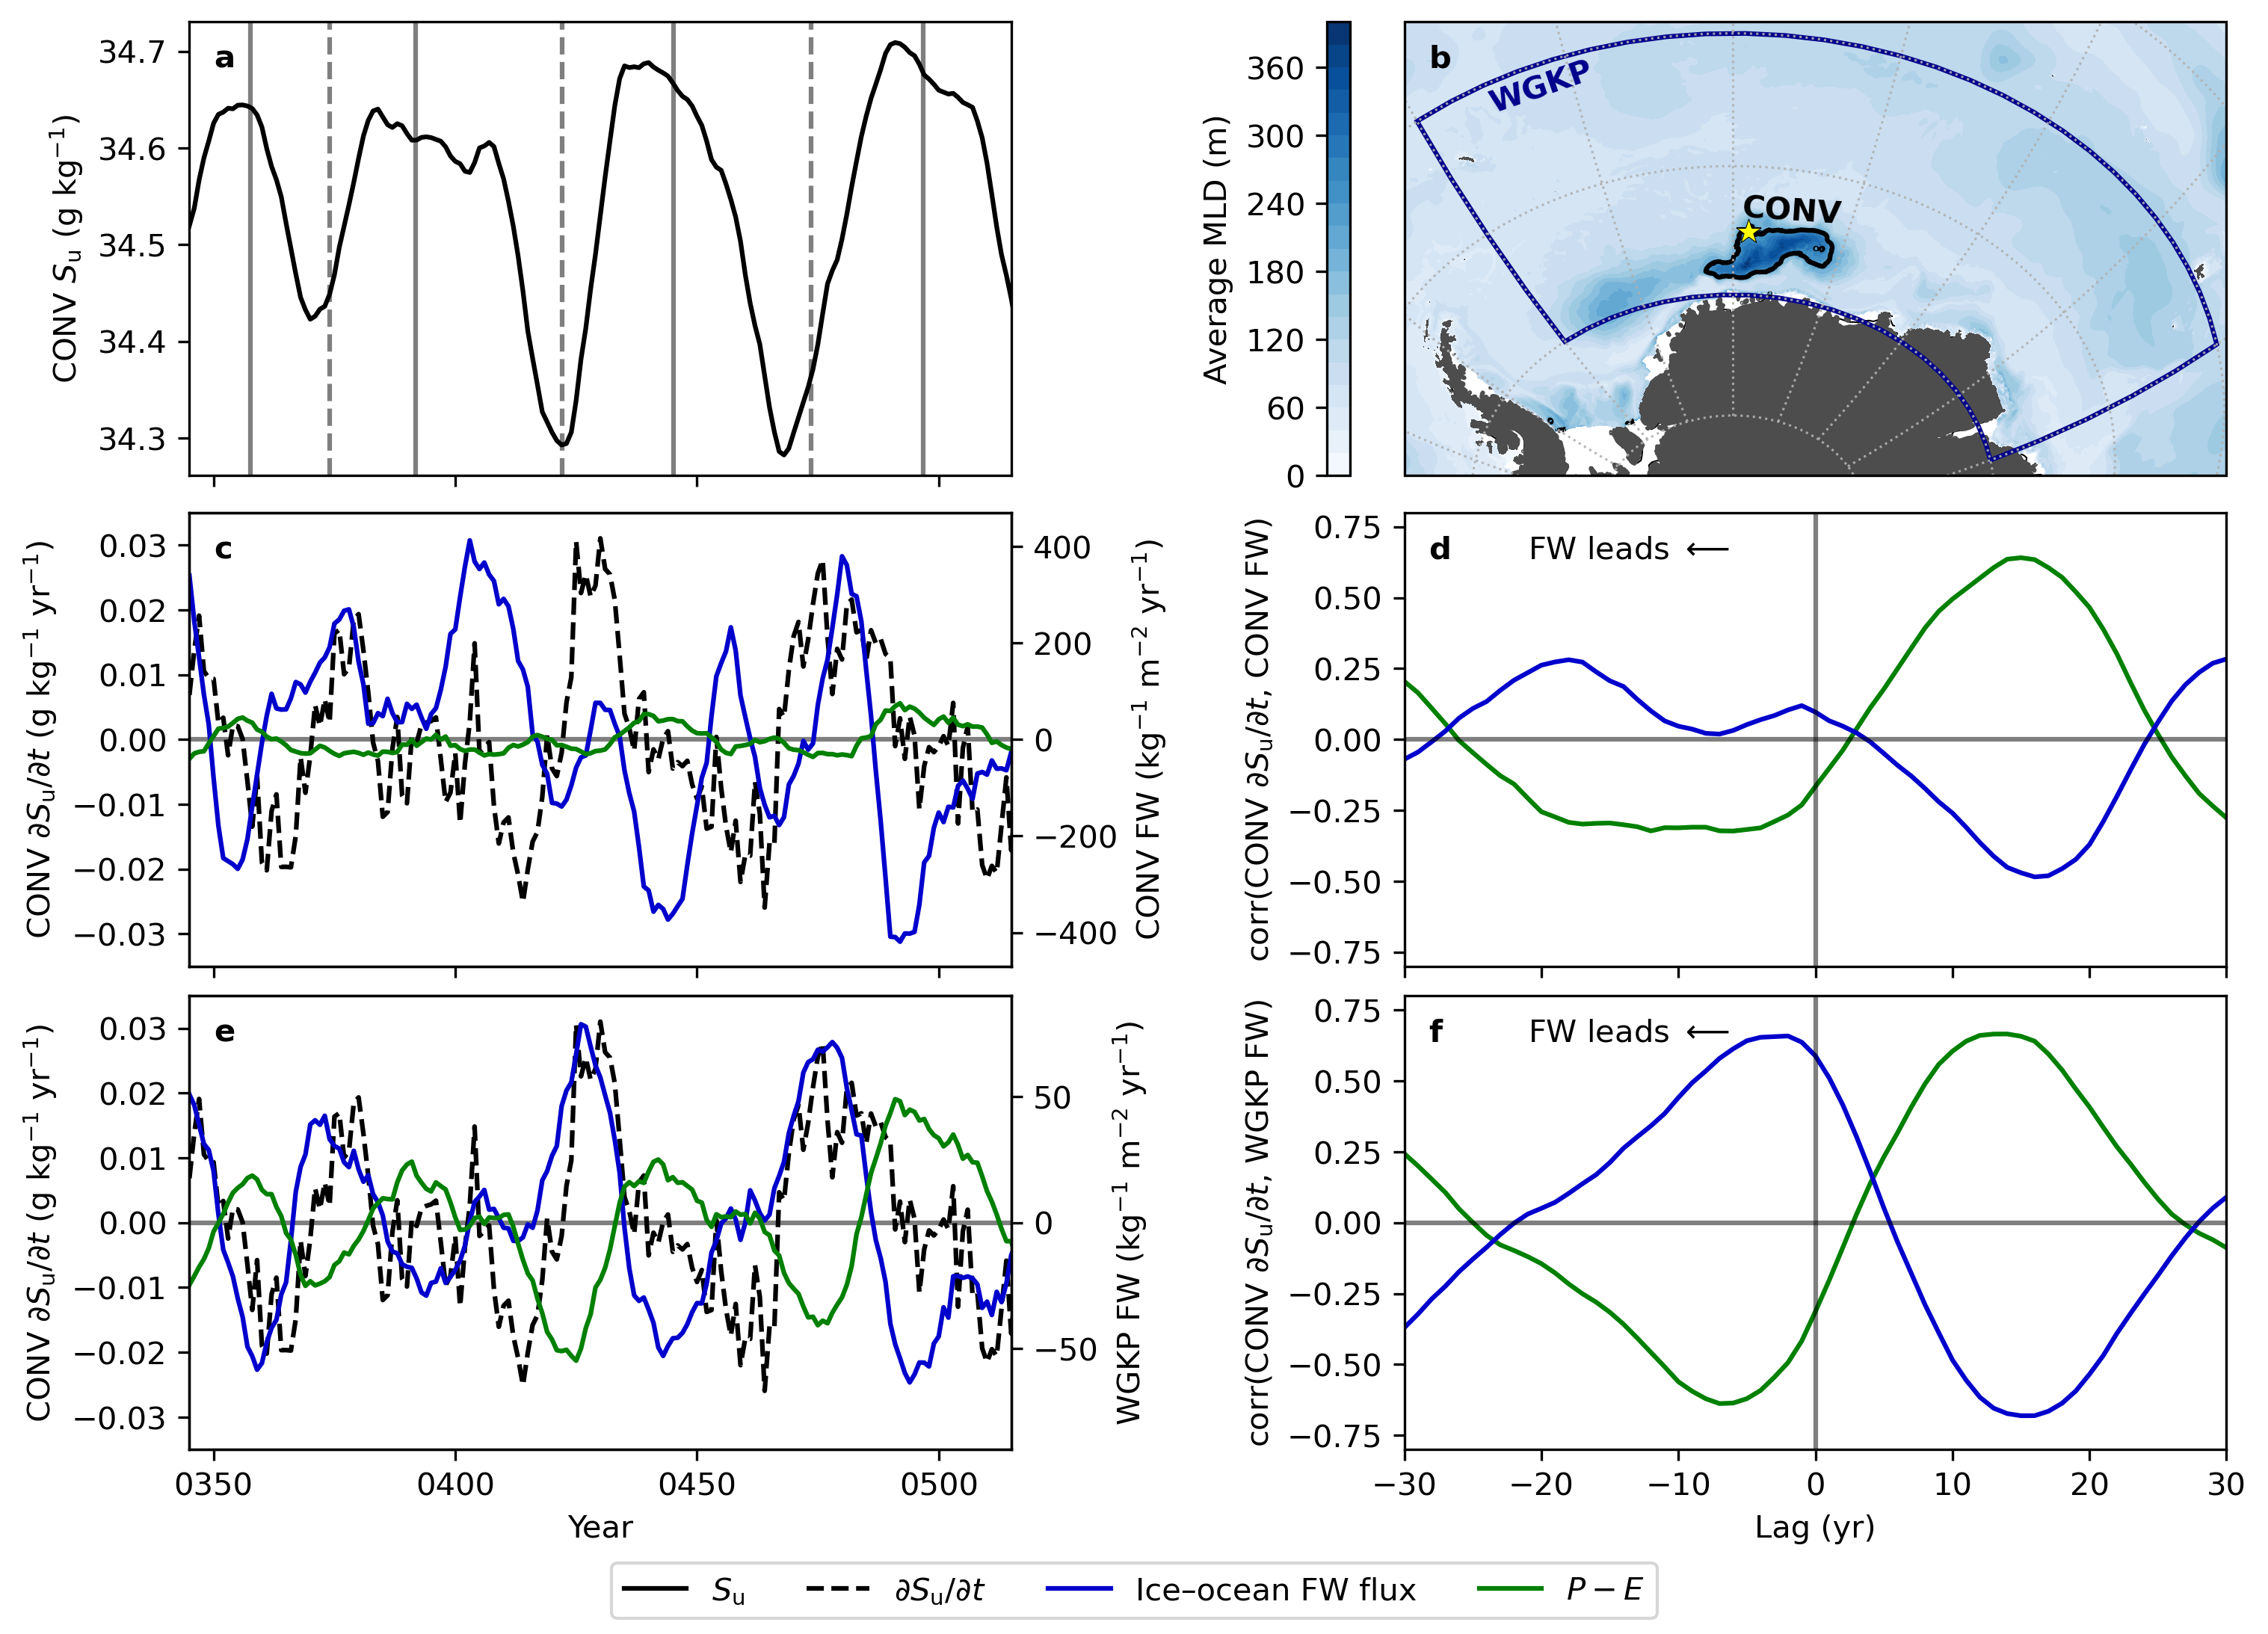

In [13]:
proj = ccrs.Orthographic(central_latitude=-50)
proj._threshold /= 100.

fig, ax = plt.subplots(3, 2, dpi=300, figsize=(10, 7.2), layout='constrained')
ax2 = ax[2, 0].twinx()
ax3 = ax[1, 0].twinx()

annual_rm(mls.SALT).plot(ax=ax[0, 0], color='k', linewidth=1.5)
plot_lfc_ext(ax[0, 0])
ax[0, 0].set_ylabel(r'CONV $S_\mathrm{u}$ (g kg$^{-1}$)')

fig.delaxes(ax[0, 1])
ax_map = fig.add_subplot(3, 2, 2, projection=proj)
ax_map.set_extent([-36, 62, -81, -43])
lons, lats, mld = z_masked_overlap(ax_map, mld_ds.TLONG.data, mld_ds.TLAT.data, (mld_ds.squeeze().HMXL/100).data, source_projection=ccrs.Geodetic())
mld_map = ax_map.contourf(lons, lats, mld, levels=21, cmap='Blues')
ax_map.contour(lons, lats, mld, levels=[220], colors='k', linewidths=1.5)
plt.colorbar(mld_map, ax=ax_map, label='Average MLD (m)', location='left', shrink=1., pad=-0.12)
ax_map.coastlines(linewidth=0.5, zorder=-1)
ax_map.gridlines(linewidth=0.75, linestyle=':', alpha=0.9, ylim=80, ylocs=np.arange(-80, -39, 10), xlocs=np.arange(-80, 81, 20))
ax_map.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), color='0.3', zorder=-1)
ax_map.add_patch(mpatches.Polygon(xy=([-40, -70], [80, -70], [80, -50], [-40, -50]), facecolor='none', edgecolor='darkblue', linewidth=1.5, transform=ccrs.PlateCarree()))
ax_map.scatter(2.7, -65, marker='*', s=70, color='yellow', edgecolors='black', linewidths=0.25, alpha=1, transform=ccrs.PlateCarree(), zorder=3)

center(rolling_mean(wg_ice, t=10)).plot(ax=ax2, color='mediumblue')
center(rolling_mean(wg_pme, t=10)).plot(ax=ax2, color='green')
center(rolling_mean(cr_dmlsdt, t=10)).plot(ax=ax[2, 0], color='k', linestyle='--')
ax[2, 0].axhline(0, color='k', alpha=0.5, zorder=-1)
ax[0, 0].set_xlim(mls.time.sel(time='0344-12').values, mls.time.sel(time='0515-01').values)
ax[2, 0].set_xlim(mls.time.sel(time='0344-12').values, mls.time.sel(time='0515-01').values)
ax2.set_ylim(-90, 90)
ax[2, 0].set_ylim(-0.035, 0.035)
ax[2, 1].set_ylim(-0.8, 0.8)

center(rolling_mean(cr_ice, t=10)).plot(ax=ax3, color='mediumblue')
center(rolling_mean(cr_pme, t=10)).plot(ax=ax3, color='green')
center(rolling_mean(cr_dmlsdt, t=10)).plot(ax=ax[1, 0], color='k', linestyle='--')
ax[1, 0].axhline(0, color='k', alpha=0.5, zorder=-1)
ax[1, 0].set_xlim(mls.time.sel(time='0344-12').values, mls.time.sel(time='0515-01').values)
ax3.set_ylim(-470, 470)
ax[1, 0].set_ylim(-0.035, 0.035)
ax[1, 1].set_ylim(-0.8, 0.8)

ax[1, 1].plot(lags, crpme_dmlsdt_lagcorr, color='green', label='$P-E$')
ax[1, 1].plot(lags, crice_dmlsdt_lagcorr, color='mediumblue', label='Ice–ocean')
# ax[1, 1].legend(loc='lower left')
ax[1, 1].set_xlim(-30, 30)
ax[1, 1].axvline(0, color='k', alpha=0.5)
ax[1, 1].axhline(0, color='k', alpha=0.5)
# ax[1, 1].set_xticks(np.arange(-360, 361, 120), ['$-30$', '$-20$', '$-10$', '$0$', '$10$', '$20$', '$30$'])
ax[1, 1].set_ylabel(r'corr(CONV $\partial S_\mathrm{u}/\partial t$, CONV FW)')

ax[2, 1].plot(lags, wgpme_dmlsdt_lagcorr, color='green', label='$P-E$')
ax[2, 1].plot(lags, wgice_dmlsdt_lagcorr, color='mediumblue', label='Ice–ocean')
ax[2, 1].set_xlim(-30, 30)
ax[2, 1].axvline(0, color='k', alpha=0.5)
ax[2, 1].axhline(0, color='k', alpha=0.5)
# ax[2, 1].set_xticks(np.arange(-360, 361, 120), ['$-30$', '$-20$', '$-10$', '$0$', '$10$', '$20$', '$30$'])
ax[2, 1].set_ylabel(r'corr(CONV $\partial S_\mathrm{u}/\partial t$, WGKP FW)')
ax[2, 1].set_xlabel('Lag (yr)')

ax[0, 0].set_xticklabels([])
ax[1, 0].set_xticklabels([])
ax[1, 1].set_xticklabels([])
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[0, 0].set_title('')
ax2.set_ylabel(r'WGKP FW (kg$^{-1}$ m$^{-2}$ yr$^{-1}$)')
ax3.set_ylabel(r'CONV FW (kg$^{-1}$ m$^{-2}$ yr$^{-1}$)')
ax[2, 0].set_ylabel(r'CONV $\partial S_\mathrm{u}/\partial t$ (g kg$^{-1}$ yr$^{-1}$)')
ax[1, 0].set_ylabel(r'CONV $\partial S_\mathrm{u}/\partial t$ (g kg$^{-1}$ yr$^{-1}$)')
ax[2, 0].set_xlabel('Year')

ax[0, 0].annotate('a', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax_map.annotate('b', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax[1, 0].annotate('c', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax[1, 1].annotate('d', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax[2, 0].annotate('e', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax[2, 1].annotate('f', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax[2, 1].annotate(r'FW leads $\longleftarrow$', xy=(0.15, 0.9), xycoords='axes fraction')
ax[1, 1].annotate(r'FW leads $\longleftarrow$', xy=(0.15, 0.9), xycoords='axes fraction')
ax_map.annotate('WGKP', xy=(0.1, 0.8), xycoords='axes fraction', fontweight='bold', rotation=19, c='darkblue')
ax_map.annotate('CONV', xy=(0.41, 0.555), xycoords='axes fraction', fontweight='bold', rotation=-4, c='k')

legend_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], color='k', linestyle='--'),
                Line2D([0], [0], color='mediumblue'),
                Line2D([0], [0], color='green'),]
fig.legend(legend_lines, [r'$S_\mathrm{u}$', r'$\partial S_\mathrm{u}/\partial t$', 'Ice–ocean FW flux', '$P-E$'], loc='outside lower center', ncols=4)

In [14]:
# fig.savefig('fw.png')